# Deep Learning
## Summative assessment
### Coursework 1

#### Instructions

This coursework is released on **Tuesday 18th February 9.00** and is due by **Tuesday 11th March 9.00**. It is worth **50%** of your overall mark. There are 4 questions in this assessment, and a total of 50 marks are available. **You should attempt to answer all questions.** In addition to the total number of marks shown per question below, an additional 5 marks is available for presentation and clarity/quality of code.

This assessment assesses your ability to design, implement, train and evaluate a deep learning model for face verification. This is the problem of determining whether or not two images are of the same person.

You can make imports as and when you need them throughout the notebook, and add code cells where necessary. Make sure your notebook executes correctly in sequence before submitting.

The data required for this assessment can also be downloaded from [this link](https://drive.google.com/file/d/1guvJwIdHKi4-AFRPs0v-6kfHZhEuo8x8/view?usp=sharing) in case you would prefer to work locally.

#### Submission instructions

The submission for this assessment will consist of a notebook (.ipynb file) and PDF report.

Ensure your notebook executes correctly in order. Save your notebook .ipynb file **after you have executed it** (so that outputs are all showing). It is recommended to also submit a PDF/HTML copy of your executed notebook, in case the .ipynb file is corrupted for some reason.

Upload a zip file containing your notebook and separate PDF/HTML file(s) by the deadline above.

This assignment must be attempted individually; your submission must be your own, unaided work. Candidates are prohibited from discussing assessed coursework, and must abide by [Imperial College’s rules](https://www.imperial.ac.uk/media/imperial-college/administration-and-support-services/registry/academic-governance/public/academic-policy/academic-integrity/Examination-and-assessments---academic-integrity.pdf) regarding academic integrity and plagiarism. Unless specifically authorised within the assignment instructions, the submission of output from [generative AI tools](https://www.imperial.ac.uk/about/leadership-and-strategy/provost/vice-provost-education/generative-ai-tools-guidance/) (e.g., ChatGPT) for assessed coursework is prohibited. Violations will be treated as an examination offence. Enabling other candidates to plagiarise your work constitutes an examination offence. To ensure quality assurance is maintained, departments may choose to invite a random selection of students to an ‘authenticity interview’ on their submitted assessments.

In [1]:
import os
import logging
from sklearn.model_selection import train_test_split
# Suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# set backend
os.environ['KERAS_BACKEND'] = 'torch'
import keras
print("Backend after setting:", keras.config.backend())

import tensorflow as tf
import torch

# Check GPU visibility
# print("TensorFlow GPUs:", tf.config.list_physical_devices('GPU'))
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Backend after setting: torch


In [2]:
'''Set GPU usage configuration'''
class Config:
    def __init__(self, device_id=0):
        self.device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Set device to GPU 1
config = Config(device_id=1)
device = config.device
torch.cuda.set_device(config.device.index)
print(torch.cuda.current_device()) 
print("PyTorch Device:", device)


1
PyTorch Device: cuda:1


#### CASIA-Webface Dataset

This assessment makes use of the CASIA-Webface dataset, which is used for face verification and face identification tasks. The complete dataset consists of 494,414 face images of 10,575 real identities collected from the web. In this assessment, a smaller subset of the dataset has been prepared for you.

The dataset was first introduced in the following paper:

*  Yi, D., Lei, Z., Liao, S. and Li, S.Z. (2014), "Learning Face Representation from Scratch", arXiv preprint, abs/1411.7923.

The data subset is available for you in the folder `./data/casia-webface`.

#### Contrastive learning

Your task in this assessment is to develop a deep learning model that can be used to verify if two images belong to the same person or not. The model will take an image as input, and output a fixed size embedding. The model will be trained such that different images belonging to the same identity should have embeddings that are close to each other (in some sense), and images belonging to different identities should have embeddings that are far apart.

The training algorithm you will use for this will be a form of contrastive learning. This is a learning paradigm where the objective function compares different examples in the dataset.

In particular, to train your model you will use a loss function that takes three examples: an anchor input $\mathbf{x}$, a positive example $\mathbf{x}^+$ that is similar to the anchor (the same identity), and a negative example $\mathbf{x}^-$ that is different to the anchor. The objective for the network is to embed the images such that the similarity between the anchor and positive example is maximised (or distance is minimised), and the similarity between the anchor and negative example is minimised (distance is maximised).

<center><img src="figures/contrastive-learning.png" alt="Similarity of representations" style="width: 450px;"/></center>
<center>The model's objective is to minimize the distance (in embedding space) between an anchor and a positive example, both of which have the same identity, and maximize the distance between the anchor and a negative example of a different identity</center>
<br>

The loss function you will use is the circle loss, given by:

$$
\mathcal{L}_{\textrm{circle}}(s_p, s_n) = \frac{1}{\gamma}\log\left[ 1 + \exp(\gamma (\alpha_n(s_n - \Delta_n) - \alpha_p(s_p - \Delta_p))\right],
$$
where $s_p$ (resp. $s_n$) is the positive (resp. negative) similarity score computed between the anchor and positive (resp. anchor and negative) examples, according to some choice of similarity measure in the embedding space. The hyperparameters $\alpha_p>0$ and $\alpha_n>0$ are example-specific weightings to emphasise either the positive or negative similarity scores in the gradient updates, and $\Delta_p>0$ and $\Delta_n>0$ are the positive and negative margins. 

The circle loss was introduced in the following paper:

* Sun, Y., Cheng, C., Zhang, Y., Zhang, C., Zheng, L. and Wang, Z. (2020), "Circle Loss: A Unified Perspective of Pair Similarity Optimization," *IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), Seattle, WA, USA*, 6397-6406.

You will need to implement a custom data loading pipeline and custom training loop, as well as designing a dedicated model architecture that produces an embedding for a given input image. Details of the data loading and training procedures will be up to you to decide. You will process the data, train and evaluate the specified model, and then write a report to summarise the experiments and results.

The data processing, model design, training algorithm and evaluation will potentially require several hyperparameter choices, and you should experiment with different choices during the development of your model. In question 4 you will write a report detailing the experiments carried out. It is up to you which experiments you will run. It is not necessary to include all experiments carried out in code in this notebook - you only need to include the code for the final choice of hyperparameters (in order to avoid overly long notebook submissions).

### Question 1 (Total 8 marks)

a) In this question, you should carry out a basic exploration and analysis of the dataset; computing, displaying and visualising any properties you deem to be relevant. For example, it will be helpful to compute the number of distinct identities in the dataset, and visualise some of the images. You can also use comments and/or markdown as appropriate.

**(3 marks)**

Total number of distinct identities: 8000
Total number of images: 211958


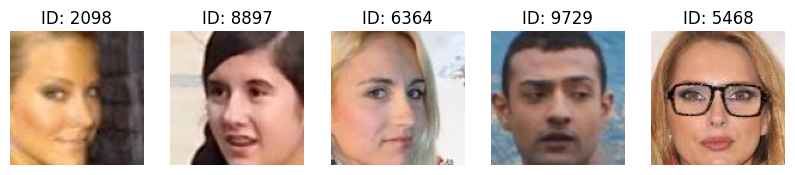

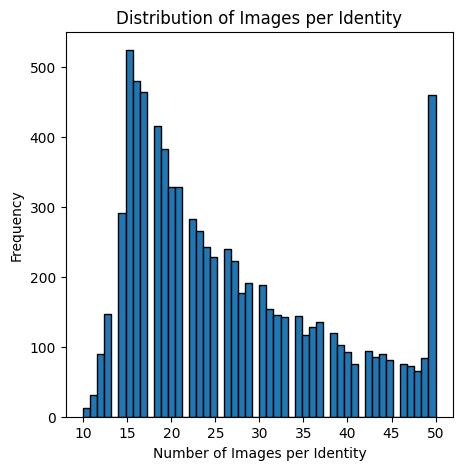

In [3]:
dataset_path = "data/casia-webface"
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Get list of identities (folders)
identities = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
num_identities = len(identities)

# Count the number of images per identity
image_counts = {identity: len(os.listdir(os.path.join(dataset_path, identity))) for identity in identities}
total_images = sum(image_counts.values())

print(f"Total number of distinct identities: {num_identities}")
print(f"Total number of images: {total_images}")

# Display some sample images
def display_sample_images(dataset_path, identities, num_samples=5):
    plt.figure(figsize=(10, 5))
    sampled_identities = random.sample(identities, min(num_samples, len(identities)))
    
    for i, identity in enumerate(sampled_identities):
        image_files = os.listdir(os.path.join(dataset_path, identity))
        if not image_files:
            continue
        image_path = os.path.join(dataset_path, identity, random.choice(image_files))
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"ID: {identity}")
        plt.axis("off")
    
    plt.show()

display_sample_images(dataset_path, identities)

# Plot a histogram of image counts per identity
plt.figure(figsize=(5, 5))
plt.hist(image_counts.values(), bins=50, edgecolor='black')
plt.xlabel("Number of Images per Identity")
plt.ylabel("Frequency")
plt.title("Distribution of Images per Identity")
plt.show()


There are 8000 distinct identities. Some identities (500 out of 8000) have 50 images, 
while most identities have 15-20 images.

Most populated identity: 6220 (50 images)


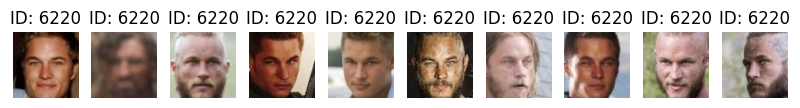

Least populated identity: 1816 (10 images)


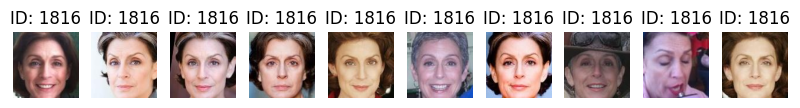

In [4]:
from PIL import Image
# Get the most and least populated identities
most_populated = max(image_counts, key=image_counts.get)
least_populated = min(image_counts, key=image_counts.get)

def display_images_from_identity(identity, num_samples=5):
    plt.figure(figsize=(10, 5))
    image_files = os.listdir(os.path.join(dataset_path, identity))
    sampled_images = random.sample(image_files, min(num_samples, len(image_files)))

    for i, img_name in enumerate(sampled_images):
        img_path = os.path.join(dataset_path, identity, img_name)
        img = Image.open(img_path)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"ID: {identity}")
        plt.axis("off")

    plt.show()

print(f"Most populated identity: {most_populated} ({image_counts[most_populated]} images)")
display_images_from_identity(most_populated, 10)

print(f"Least populated identity: {least_populated} ({image_counts[least_populated]} images)")
display_images_from_identity(least_populated, 10)


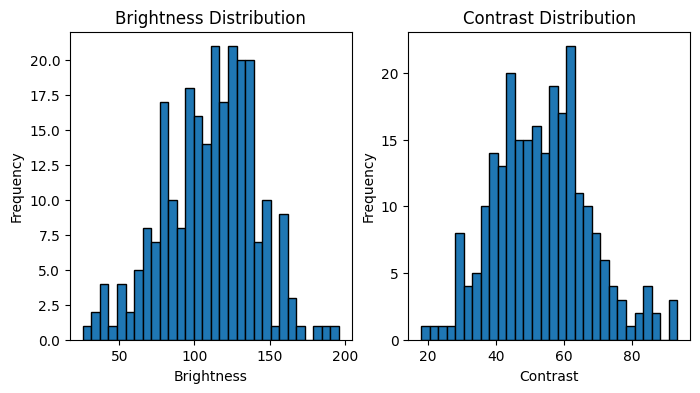

In [5]:
def compute_brightness_contrast(image_path):
    img = Image.open(image_path).convert("L")  # Convert to grayscale
    img_array = np.array(img)
    brightness = np.mean(img_array)
    contrast = np.std(img_array)
    return brightness, contrast

brightness_vals, contrast_vals = [], []

for identity in random.sample(identities, min(len(identities), 50)):
    image_files = os.listdir(os.path.join(dataset_path, identity))
    for img_name in random.sample(image_files, min(len(image_files), 5)):
        img_path = os.path.join(dataset_path, identity, img_name)
        b, c = compute_brightness_contrast(img_path)
        brightness_vals.append(b)
        contrast_vals.append(c)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(brightness_vals, bins=30, edgecolor="black")
plt.xlabel("Brightness")
plt.ylabel("Frequency")
plt.title("Brightness Distribution")

plt.subplot(1, 2, 2)
plt.hist(contrast_vals, bins=30, edgecolor="black")
plt.xlabel("Contrast")
plt.ylabel("Frequency")
plt.title("Contrast Distribution")

plt.show()

We also want to check the shape of each image.

In [6]:
image_shapes = []

for identity in identities[:3]:  # Check 3 random identities
    image_files = os.listdir(os.path.join(dataset_path, identity))
    
    for img_name in image_files[:2]:  # Check 2 images per identity
        img_path = os.path.join(dataset_path, identity, img_name)
        with Image.open(img_path) as img:
            print(f"Image: {img_name}, Size: {img.size}")  # img.size gives (width, height)
            image_shapes.append(img.size)

print("Unique image shapes:", set(image_shapes))


Image: 000005.jpeg, Size: (112, 112)
Image: 000001.jpeg, Size: (112, 112)
Image: 000002.jpeg, Size: (112, 112)
Image: 000006.jpeg, Size: (112, 112)
Image: 000036.jpeg, Size: (112, 112)
Image: 000007.jpeg, Size: (112, 112)
Unique image shapes: {(112, 112)}


b) Create the dataset object(s) that you will use to train and evaluate your model. The only requirements for your datasets are as follows:

* You should use either TensorFlow Datasets or PyTorch Datasets/DataLoaders. 
* A number of identities should be selected, and for each identity a maximum number of images should be selected.
* The dataset should return an aligned pair of Tensors `(identities, images)` with shapes `(N,)` and `(N, height, width, channels)`, where `N` is the total number of images selected across all selected identities.

You can use any tools from Keras, TensorFlow or PyTorch that might be useful for this task.

Demonstrate that your dataset creation and processing is working as intended.

**(5 marks)**

In [7]:
import os
import random
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, Sampler

class PytorchFaceDataset(Dataset):
    """
    A single unified class that:
      - Loads up to `max_images_per_identity` images from each identity folder.
      - Optionally uses `sample_indexes` for train/val slicing.
    """
    def __init__(
        self, dataset_path, identities,
        max_images_per_identity=10,
        sample_indexes=None,
        classes_per_batch=None,
        samples_per_class=None
    ):
        self.dataset_path = dataset_path
        self.identities = identities
        self.max_images_per_identity = max_images_per_identity
        self.sample_indexes = sample_indexes
        self.classes_per_batch = classes_per_batch
        self.samples_per_class = samples_per_class

        self.image_paths = []
        self.labels = []  # We'll group by label = idx in `identities`
        
        # Gather all images & labels
        for idx, identity in enumerate(identities):
            identity_folder = os.path.join(dataset_path, identity)
            if not os.path.isdir(identity_folder):
                continue  # skip if folder doesn't exist

            image_files = sorted(os.listdir(identity_folder))
            # Take up to max_images_per_identity images
            selected_images = image_files[:max_images_per_identity]
            for img_name in selected_images:
                self.image_paths.append(os.path.join(identity_folder, img_name))
                self.labels.append(idx)

        # sample_indexes is train_indices or val_indices
        if self.sample_indexes is not None:
            self.image_paths = [self.image_paths[i] for i in self.sample_indexes]
            self.labels = [self.labels[i] for i in self.sample_indexes]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        label = self.labels[index]

        # Load image, convert to RGB, resize to (112, 112)
        img = Image.open(img_path).convert("RGB")
        img = img.resize((112, 112), resample=Image.BILINEAR)
        # Normalize to [0, 1]
        img = np.array(img, dtype=np.float32) / 255.0  # shape: (112, 112, 3)

        img_tensor = torch.from_numpy(img)  # currently (112, 112, 3)

        return img_tensor, label

    def get_dataloader(self, batch_size=128, shuffle=True, num_workers=4):
        # If we have custom-batch parameters set, build the custom sampler
        if self.classes_per_batch is not None and self.samples_per_class is not None:
            return DataLoader(
                self,
                batch_sampler=self._BatchSampler(
                    self.labels,
                    self.classes_per_batch,
                    self.samples_per_class
                ),
                num_workers=num_workers
            )
        else:
            return DataLoader(
                self,
                batch_size=batch_size,
                shuffle=shuffle,
                num_workers=num_workers
            )

    class _BatchSampler(Sampler):
        """
        Ensures each batch contains `classes_per_batch` classes, each has
        `samples_per_class` samples or fewer.
        """
        def __init__(self, labels, classes_per_batch, samples_per_class):
            self.labels = labels
            self.classes_per_batch = classes_per_batch
            self.samples_per_class = samples_per_class

            # Group indices by class
            self.class_to_indices = {}
            for idx, label in enumerate(labels):
                self.class_to_indices.setdefault(label, []).append(idx)

            # Keep list of all classes for shuffling each epoch
            self.all_classes = list(self.class_to_indices.keys())

        def __iter__(self):
            '''Defines how the batch indices are generated.'''
            random.shuffle(self.all_classes) # Shuffle list of all labels each epoch

            # We'll chunk the shuffled class list in groups of 'classes_per_batch'

            # loop over shuffled classes in chunks of 'classes_per_batch'
            # e.g. 8000 classes, 10 class per epoch, so 800 iterations
            for start in range(0, len(self.all_classes), self.classes_per_batch):
                chunk_classes = self.all_classes[start:start + self.classes_per_batch]
                
                batch_indices = []
                for cls in chunk_classes: # collect sample indices for each class
                    idx_list = self.class_to_indices[cls] # map label to indices

                    # if a class has enough samples, sample 'samples_per_class' indices
                    # otherwise, take all indices
                    if len(idx_list) >= self.samples_per_class:
                        chosen = random.sample(idx_list, self.samples_per_class)
                    else:
                        chosen = idx_list  # class is smaller than desired
                    batch_indices.extend(chosen)

                yield batch_indices # move to dataloader

        def __len__(self):
            ''' computes how many batches are needed to cover all classes '''
            # e.g. 8000 class, 10 class per batch, so (8010-1) // 10 = 800
            return (len(self.all_classes) + self.classes_per_batch - 1) // self.classes_per_batch


In [8]:
# # Load dataset identities
dataset_path = "data/casia-webface"
identities = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print("Number of identities in dataset:", len(identities))
indices = np.arange(80000)
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)
train_torch_dataset = PytorchFaceDataset(dataset_path, identities, 
                                         max_images_per_identity=10, 
                                         sample_indexes=train_indices,
                                         classes_per_batch=10,   # each batch will pick 10 classes
                                        samples_per_class=10) # each class has 10 samples
train_loader = train_torch_dataset.get_dataloader(num_workers=4) # batch size = 10*10=100
val_torch_dataset = PytorchFaceDataset(dataset_path, identities,
                                       max_images_per_identity=10, 
                                       sample_indexes=val_indices,
                                       classes_per_batch=10,   # each batch will pick 10 classes
                                       samples_per_class=10) # each class has 10 samples
val_loader = val_torch_dataset.get_dataloader(num_workers=4) # batch size = 10*10=100

# Check shape
for images, labels in train_loader:
    print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
    print("Unique labels in this batch:", len(set(labels.tolist())))
    break


Number of identities in dataset: 8000


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Images shape: torch.Size([72, 112, 112, 3]), Labels shape: torch.Size([72])
Unique labels in this batch: 10


### Question 2 (Total 20 marks)

a) Recall the circle loss is given by

$$
\mathcal{L}_{\textrm{circle}}(s_p, s_n) = \frac{1}{\gamma}\log\left[ 1 + \exp(\gamma (\alpha_n(s_n - \Delta_n) - \alpha_p(s_p - \Delta_p))\right],\tag{1}
$$

where $\alpha_p>0$, $\alpha_n>0$, $\Delta_p>0$ and $\Delta_n>0$ are hyperparameters, and $s_p$ and $s_n$ are the similarity scores between anchor-positive and anchor-negative pairs according to some similarity measure.

The [triplet loss](https://en.wikipedia.org/wiki/Triplet_loss) is a similar loss function for contrastive learning that was developed a few years earlier. It is given by:

$$
\mathcal{L}_{\textrm{triplet}}(\mathbf{x}, \mathbf{x}^+, \mathbf{x}^-) =  \max(0, || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+) ||_2^2 - || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-) ||_2^2  + m)\tag{2}
$$

where $f_\theta$ is a network that maps images to a fixed-size embedding, $\mathbf{x}$ is an anchor example, $\mathbf{x}^+$ is a corresponding positive example, and $\mathbf{x}^-$ is a negative example, and $m>0$ is a hyperparameter that sets the minimum offset between distances of similar vs dissimilar pairs. 

Show that the triplet loss can be derived from the circle loss as a certain limit, with a certain choice of hyperparameters $\alpha_p$, $\alpha_n$, $\Delta_p$ and $\Delta_n$ and similarity measure.

**(2 marks)**

We know that the Softplus function $ \log(1 + e^z) $ is an approximation of ReLU: $\max(0, z)$

When we scale it with $\gamma$, the transition at 0 gets sharper until it behaves like $\max(0, z)$ when $ \gamma \to \infty$:
$$
\max(0,\,z) = Relu(z) =
\lim_{\gamma\to\infty}\;\frac{1}{\gamma}\,\log\bigl(1 + e^{\gamma\,z}\bigr).
$$
Hence as $\gamma \to \infty$:
$$
\mathcal{L}_{\textrm{circle}}(s_p, s_n) \to \max\bigl(0,\;\alpha_n\,(s_n - \Delta_n) - \alpha_p\,(s_p - \Delta_p)\bigr)
$$

Let
$$
s_p 
= 
-\frac{\,\bigl\|\!f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+)\bigr\|_2^2}{\alpha_p},
\quad
s_n 
= 
-\frac{\,\bigl\|\!f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-)\bigr\|_2^2}{\alpha_n}.
$$
$$
\Delta_p = -\,\frac{m}{2\,\alpha_p}, 
\quad
\Delta_n = \frac{m}{2\,\alpha_n},
$$

Then
$$
\alpha_p\,(s_p - \Delta_p)
= 
-\,\|f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+)\|_2^2 \;+\;\frac{m}{2},
$$
$$
\alpha_n\,(s_n - \Delta_n)
=
-\,\|f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-)\|_2^2 \;-\;\frac{m}{2}
$$

so that
$$
\alpha_n\,(s_n - \Delta_n) \;-\;\alpha_p\,(s_p - \Delta_p)
=
-\,\|f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-)\|_2^2 
\;+\;
\|f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+)\|_2^2
\;+\; m.
$$

Therefore,
$$
\mathcal{L}_{\mathrm{circle}}(s_p, s_n)
\;\;\xrightarrow[\gamma\to\infty]{}\;\;
\max\Bigl(0,\;
\|f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+)\|_2^2
\;-\;
\|f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-)\|_2^2
\;+\; m
\Bigr),
$$


b) You will use the circle loss to train your model. Following Sun et al., we will assume that the similarity score takes values between 0 and 1. A suitable choice of similarity measure that satisfies this is the scaled cosine similarity $s(\mathbf{x}_1, \mathbf{x}_2) = (\langle \mathbf{x}_1, \mathbf{x}_2 \rangle + 1) / 2$, where $\mathbf{x}_1$ and $\mathbf{x}_2$ have been normalised such that $||\mathbf{x}_1||_2 = ||\mathbf{x}_2||_2 = 1$.

With this choice, typical settings for the hyperparameters in the circle loss are

$$
\begin{align}
\alpha_p &= 1 + m - s_p\\
\alpha_n &= s_n + m\\
\Delta_p &= 1 - m\\
\Delta_n &= m
\end{align}
$$

where $0<m<1$ is the _margin_. These settings reduce the hyperparameters in the loss function to just one (the margin $m$).

Write a function `circle_loss` to implement the circle loss as described above. Your loss function implementation should therefore take the following arguments:

* `anchor_embeddings`, a Tensor of shape `(N, d)`: the $\ell_2$-normalised model embeddings for the anchor images
* `positive_embeddings`, a Tensor of shape `(N, d)`: the $\ell_2$-normalised model embeddings for the corresponding positive images
* `negative_embeddings`, a Tensor of shape `(N, d)`: the $\ell_2$-normalised  model embeddings for the corresponding negative images
* `m`, a float value between zero and 1: the margin
* `gamma`, a positive float: scaling hyperparameter in the circle loss

**(2 marks)**

We note that in this case, the circle loss is given by
$$
\mathcal{L}_{\textrm{circle}}(s_p, s_n) = \frac{1}{\gamma}\log\left[ 1 + \exp(\gamma z\right)]
$$
Where
$$
z = s_n^2 + (s_p - 1)^2 - 2m^2
$$

In [9]:
import torch
import torch.nn.functional as F

def circle_loss_torch(anchor_embeddings, positive_embeddings, negative_embeddings, m=0.25, gamma=64.0):
    # -- Step 1: Compute scaled cosine similarities in [0, 1].
    s_p = ((anchor_embeddings * positive_embeddings).sum(dim=1) + 1.0) / 2.0
    s_n = ((anchor_embeddings * negative_embeddings).sum(dim=1) + 1.0) / 2.0

    alpha_p = 1.0 + m - s_p
    alpha_n = s_n + m
    delta_p = 1.0 - m
    delta_n = m

    # We'll compute this in a vectorized way and then average across the batch.
    inside_term = gamma * (alpha_n * (s_n - delta_n) - alpha_p * (s_p - delta_p))
    losses = (1.0 / gamma) * torch.log1p(torch.exp(inside_term))  # log1p(x) = log(1 + x)
    
    return losses.mean()


c) You should design and implement a model that will be trained on the face verification task, using the circle loss defined above. 

The only specifications for your model is that it should take a batch of images as input, and return a batch of embeddings as output. Each embedding will be a fixed-size vector in $\mathbb{R}^d$ (and you are also free to choose $d$). The embeddings should be normalised to have unit $\ell_2$ norm.

Your model should be defined entirely using Keras. Print the model summary to show details of your chosen design.

**(3 marks)**

We want to use CNN layers for feature extraction, followed by dense layers with BatchNormalization(), ReLU and dropout layers, and finally output layers that output (128,) normalized embeddings.

We specifically use ReLU as the activation for all layers, instead of sigmoid to avoid gradient vanishing, which I encountered before I made this change.

We also used He Kaiming initialization for layer weights.

In [10]:
from keras.models import Sequential
from keras import regularizers
from keras.layers import (Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, 
                          Flatten, Dense, Dropout, Lambda)
from keras.initializers import HeNormal
import keras.ops as K

def get_model(hidden_units, output_units, input_shape, rate, l2_coeff=1e-5):
    """
    Creates a face verification model that outputs normalized embeddings.
    """

    model = Sequential([Input(shape=input_shape)])

    # --- Convolutional blocks / Feature extraction backbone ---

    # note we use he kaiming initialization for the weights
    model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=HeNormal(),
                     kernel_regularizer=regularizers.l2(l2_coeff)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D((2, 2)))

    # 2nd block
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=HeNormal(),
                     kernel_regularizer=regularizers.l2(l2_coeff)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D((2, 2)))

    # 3rd block
    model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=HeNormal(),
                     kernel_regularizer=regularizers.l2(l2_coeff)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    # --- Fully connected layers ---
    for units in hidden_units:
        model.add(Dense(units, kernel_initializer=HeNormal(),
                        kernel_regularizer=regularizers.l2(l2_coeff)))
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Dropout(rate))

    # --- Output layer + normalization ---
    model.add(Dense(output_units, kernel_initializer=HeNormal()))
    model.add(Lambda(lambda x: x / keras.ops.norm(x, axis=1, keepdims=True)))

    return model

model = get_model(
    hidden_units=[1024, 128],
    output_units=128,
    input_shape=(112, 112, 3),
    rate=0.5
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 25,937,600 (98.94 MB)

 Trainable params: 25,934,848 (98.93 MB)

 Non-trainable params: 2,752 (10.75 KB)

d) You should now write a function `get_triplets` that will take a batch of data from your dataset, along with the model, and any other options that you need to pass in. This function should return a list of tuples, where each tuple consists of three integers `(anchor_index, positive_index, negative_index)`. These three integers should correspond to batch indices in your data for anchor, positive and negative images respectively.

There are several ways that triplets can be selected from a batch of data, and the selection criteria often has a significant effect on the model training. It is recommmended that you experiment with different methods for triplet selection. 

A common strategy is to select triplets based on similarity scores that are being predicted by the model at a given stage in the training. This is done to ensure that the selected triplets provide an appropriate level of difficulty for the model. 

Demonstrate your function is working correctly by applying it to a batch of data and your (randomly initialised) model, and displaying some of the triplets selected.

*Hint: The FaceNet paper (which introduced the triplet loss in question 2a) contains some suggestions for triplet selection, which you might find useful to look at:*

* Schroff, F., Kalenichenko, D. and Philbin, J. (2015), "FaceNet: A unified embedding for face recognition and clustering," *IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Boston, MA, USA*, 815-823.

**(7 marks)**

In [11]:
def get_triplets(model, batch_data, margin=0.2, validation=False):
    """Selects hard triplets from a batch for triplet loss."""
    images, labels = batch_data  # Unpack batch
    labels = labels.cpu().numpy()  # Convert labels to numpy array

    with torch.no_grad():
        embeddings = model(images)
    
    # Compute pairwise distances
    batch_size = embeddings.shape[0] # should be 1024
    distances = torch.cdist(embeddings, embeddings, p=2)  # Euclidean dist

    triplets = []
    
    for anchor_idx in range(batch_size):
        anchor_label = labels[anchor_idx]

        # Find positive indices
        positive_indices = np.where(labels == anchor_label)[0]
        positive_indices = positive_indices[positive_indices != anchor_idx]  # Exclude anchor

        # Find negative indices
        negative_indices = np.where(labels != anchor_label)[0]
        
        if len(positive_indices) == 0 or len(negative_indices) == 0:
            continue  # Skip if we can't form a triplet

        # Select the hardest positive (farthest within same class)
        hardest_positive_idx = max(positive_indices, key=lambda i: distances[anchor_idx, i].item())

        # semi-hard negative, need to have bigger distance than hardest positive
        semi_hard_negatives = [i for i in negative_indices if distances[anchor_idx, i] > distances[anchor_idx, hardest_positive_idx]]
        if len(semi_hard_negatives) == 0:
            continue
        else:
            # neg_inx = random.choice(semi_hard_negatives) # randomly choose one negative
            hardest_negative_idx = min(semi_hard_negatives, key=lambda i: distances[anchor_idx, i].item())

        if validation: # this is for validation accuracy
            # Don't need margin condition, random select neg indice
            neg_inx = random.choice(negative_indices)
            triplets.append((anchor_idx, hardest_positive_idx, neg_inx))
            return triplets
        
        # For training, need to ensure valid triplet (margin condition)
        if distances[anchor_idx, hardest_negative_idx] - distances[anchor_idx, hardest_positive_idx] > margin:
            triplets.append((anchor_idx, hardest_positive_idx, hardest_negative_idx))

    return triplets


We note that in our case, the batch_size consists of 10 identities, each with no more than 10 images. Some identities may have less than 10 images, because we took 10 images from each identity, followed by random train-test-split to make the dataloader. 

Hence a batch would have no more than 100 images.

In [12]:
for batch, labels in train_loader:
    print(batch.shape, 'batch shape')
    print(labels.shape, 'labels shape')
    break

torch.Size([81, 112, 112, 3]) batch shape
torch.Size([81]) labels shape


We also check how many triplets are formed. Each triplet is formed by taking an image as the anchor, taking the hardest positive (which always exists), and a semi-negative whose initial embedding distance with anchor is bigger than the positive distance. We take the argmin index of this distance. 

The reason we choose semi-negative instead of hard-negative (image of different identity that has smallest distance with anchor) is because when we initialized the model, the distance depends on random initializations only, but we want negative distance to be bigger than positive distance.

In [13]:
for images, labels in train_loader:
    triplets = get_triplets(model, (images.to(device), labels.to(device)), margin=1e-5)
    print(f"Number of triplets: {len(triplets)}")
    print("Sample triplet:", triplets[0])
    anchor = triplets[0][0]
    print(images[anchor].shape) # anchor image shape
    break

Number of triplets: 75
Sample triplet: (0, 4, 64)
torch.Size([112, 112, 3])


e) You should now write and execute a custom training loop to train your model. Your custom training loop should use the `circle_loss` and `get_triplets` functions defined in parts b) and c).

Your custom training loop should use a Keras optimizer to perform the gradient updates. It should also record performance metrics as the training progresses. It is advised to structure your training loop to regularly save your model during training.

Display the final loss and any other performance metrics for your best trained model.

**(6 marks)**

My train_step is using triplets (anchor, pos, neg), where neg is a semi-negative index that is guaranteed to have larger distance to anchor than the positive index, as we select triplets using `get_triplet` at each epoch

In [14]:
def pt_train_step(mlp_model, loss_fn, opt, train_batch):
    """PyTorch training step for triplet loss."""
    mlp_model.zero_grad()

    (anchor, positive, negative) = train_batch

    anchor_embed = mlp_model(anchor)  # Shape: (batch_size, embedding_dim)
    positive_embed = mlp_model(positive)
    negative_embed = mlp_model(negative)

    loss = loss_fn(anchor_embed, positive_embed, negative_embed)

    loss.backward()

    # grads = [param.grad for param in mlp_model.parameters()]
    grads = [v.value.grad for v in mlp_model.trainable_variables]

    # return loss.item(), grads
    return loss, grads


The valid step is done by using triplets (anchor, pos, neg), where the neg index is randomly selected, and the neg dist may be smaller than pos dist, hence relying on our model to make the classification.

The validation acc is basically the ratio of which my model can conclude the pos dist is smaller than the negative distance, where
each distance is the euclidean distance of the embeddings

In [15]:
def pt_valid_step(mlp_model, val_batch):
    """PyTorch validation step for triplet loss."""
    (anchor, positive, negative) = val_batch

    anchor_embed = mlp_model(anchor)  # Shape: (batch_size, embedding_dim)
    positive_embed = mlp_model(positive)
    negative_embed = mlp_model(negative)
    
    pos_dist = torch.norm(anchor_embed - positive_embed, dim=1)  # Distance A→P
    neg_dist = torch.norm(anchor_embed - negative_embed, dim=1)  # Distance A→N
    # check what percentage of data has anchor_embed closer to positive_embed than negative_embed


    correct = (pos_dist < neg_dist).float()  # 1 if correct, 0 if incorrect
    accuracy = correct.mean().item()
    return accuracy

In [16]:
# we define Keras metrics for training and validation
loss_metric = keras.metrics.Mean()
accuracy_metric = keras.metrics.SparseCategoricalAccuracy()
val_accuracy_metric = keras.metrics.Mean() 

When I define `train_model_custom`, the logic is to loop over the train_loader at each epoch, using `get_triplet` to select triplets where the neg index is the smallest whose dist is larger than the hardest pos index (pos index with largest distance to anchor), use `train_step_fn` to perform gradient descent and update parameters, and record the triplet train loss. 

Then I loop over the valid dataloader, where triplets are selected such that the pos index is the hardest, and the neg index is random. This is to check accuracy of model to be able to tell a random negative index is further to anchor than the hardest positive. A completely random model should have acc < 0.5, since we are using the hardest positive at each epoch. My model's acc is larger than 0.5 in the epoch, but doesn't really increase with more epochs.

I noticed that loss also stops dropping basically within the first 3 epochs. 

Hence I did not use techniques like earlystop when valid acc stops increasing for `patience` number of epochs, saving checkpoints every 10 epochs or so, etc. Instead I manually set the model to train for 5 epochs, and save checkpoint (model weights, val acc as a json) at every epoch.

In [17]:
def train_model_custom(mlp_model, loss_fn, opt, training_dataset, validation_dataset, train_step_fn, valid_step_fn, epochs):
    """
    Train the model and evaluate on a validation set.
    Returns lists of training and validation losses/accuracies.
    """
    # check if training is using GPU
    device = config.device
    print(f"Device: {device}")
    mlp_model.to(device)
    print("Training on GPU:", next(mlp_model.parameters()).is_cuda)

    epoch_losses = []
    val_epoch_acc = []

    for epoch in range(epochs):
        print(f"Epoch {epoch}/{epochs}")
        # Reset metrics for new epoch
        loss_metric.reset_state()
        val_accuracy_metric.reset_state()
        
        # Training loop
        for images, labels in training_dataset:
            triplets = get_triplets(model, (images.to(device), labels.to(device)), margin=1e-5) # triplet indices
            anchors = [triplet[0] for triplet in triplets] # anchor indices
            positives = [triplet[1] for triplet in triplets] # positive indices
            negatives = [triplet[2] for triplet in triplets] # negative indices

            triplet_data = (images[anchors], images[positives], images[negatives])
            loss, grads = train_step_fn(mlp_model, loss_fn, opt, train_batch=triplet_data)


            opt.apply_gradients(zip(grads, mlp_model.trainable_variables))
            
            loss_metric.update_state(loss)

        # Compute training loss and accuracy
        avg_epoch_loss = float(loss_metric.result().cpu().numpy())

        # Validation loop
        with torch.no_grad():  # Disable gradients for validation
            for images, labels in validation_dataset:
                triplets = get_triplets(model, (images.to(device), labels.to(device)), margin=1e-5, validation=True)
                anchors = [triplet[0] for triplet in triplets]
                positives = [triplet[1] for triplet in triplets]
                negatives = [triplet[2] for triplet in triplets]
                triplet_data = (images[anchors], images[positives], images[negatives])
                acc = valid_step_fn(mlp_model, val_batch=triplet_data)
                val_accuracy_metric.update_state(acc)

        # Compute validation loss and accuracy
        avg_val_acc = float(val_accuracy_metric.result().cpu().numpy())

        # Store epoch results
        epoch_losses.append(avg_epoch_loss)
        # val_epoch_losses.append(avg_val_loss)
        val_epoch_acc.append(avg_val_acc)

        # Print progress
        print(f"Epoch {epoch}: loss - {avg_epoch_loss:.4f}, ")
        print(f"val_acc - {avg_val_acc:.4f}")

        # save checkpoint
        checkpoint_dir = "checkpoint"
        os.makedirs(checkpoint_dir, exist_ok=True)

        # Save the model
        mlp_model.save(os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.keras"))

        # Save metadata with json
        metadata = {
            'epoch': epoch,
            'val_accuracy': avg_val_acc
        }
        import json
        with open(os.path.join(checkpoint_dir, f"checkpoint_metadata_epoch_{epoch}.json"), "w") as f:
            json.dump(metadata, f)


    return epoch_losses


In [18]:
optimizer = keras.optimizers.SGD(learning_rate=0.05)

epoch_losses = train_model_custom(model, loss_fn=circle_loss_torch, opt=optimizer,
                                            training_dataset=train_loader, 
                                            validation_dataset=val_loader, 
                                            train_step_fn=pt_train_step, 
                                            valid_step_fn=pt_valid_step,
                                            epochs=5)

Device: cuda:1
Training on GPU: True
Epoch 0/5
Epoch 0: loss - 0.3936, 
val_acc - 0.6159
Epoch 1/5
Epoch 1: loss - 0.3961, 
val_acc - 0.7137
Epoch 2/5
Epoch 2: loss - 0.3939, 
val_acc - 0.7584
Epoch 3/5
Epoch 3: loss - 0.3931, 
val_acc - 0.7821
Epoch 4/5
Epoch 4: loss - 0.3926, 
val_acc - 0.7626


#### Question 3 (Total 7 marks)

In this question you will view your trained model as a binary classifier that predicts whether two images are the same person or not. You will test your trained model on a subset of the Labeled Faces in the Wild (LFW) dataset. This dataset also consists of a number of identities, and a number of images per identity. It was introduced in the following paper:

* Huang, G.B., Ramesh, M., Berg, T., and Learned-Miller, E. (2007), "Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments", University of Massachusetts, Amherst, Technical Report 07-49.

The subset is available for you in the folder `./data/labeled-faces-in-the-wild`.  There is also the file `lfw_test_pairs.txt` in the `./data` folder that you will use for testing. This file lists a number of pairs of images in the LFW dataset that either belong to the same identity or different identities.

_NB: if you have not been able to successfully train a model in question 2, you can still complete all of question 3 using any Keras model that takes images as input and returns embeddings. The results may not be good, but you can still demonstrate the methodology and implementation for testing the model._

a) You will now use your best model from question 2 to compute predictions on the LFW subset to say whether or not two images are the same person. 

Apply any appropriate data preprocessing to the images, and compute model embeddings and similarity scores for all images in the test data.

Display a histogram with the distribution of positive and negative similarity scores from your model.

**(4 marks)**

In [19]:
import os

pairs_txt = "./data/lfw_test_pairs.txt"   
lfw_root  = "./data/labeled-faces-in-the-wild"       

pairs = []  # will store tuples of (image1_path, image2_path, label)

with open(pairs_txt, 'r') as f:
    first_line = f.readline().strip()
    n_folds, n_pairs_per_fold = first_line.split() # 10 300
    n_folds, n_pairs_per_fold = int(n_folds), int(n_pairs_per_fold)

    # For each of the 10 folds:
    for _ in range(n_folds):
        # 1) Parse the POSITIVE (same-person) pairs => 3 columns each
        for _ in range(n_pairs_per_fold):
            line = f.readline().strip().split()
            person   = line[0]
            img_idx1 = int(line[1])
            img_idx2 = int(line[2])
            label    = 1  # same person

            img1_path = os.path.join(lfw_root, person, f"{person}_{img_idx1:04d}.jpg")
            img2_path = os.path.join(lfw_root, person, f"{person}_{img_idx2:04d}.jpg")

            pairs.append((img1_path, img2_path, label))

        # 2) Parse the NEGATIVE (different-person) pairs => 4 columns each
        for _ in range(n_pairs_per_fold):
            line = f.readline().strip().split()
            person1   = line[0]
            img1_idx  = int(line[1])
            person2   = line[2]
            img2_idx  = int(line[3])
            label     = 0  # different persons

            img1_path = os.path.join(lfw_root, person1, f"{person1}_{img1_idx:04d}.jpg")
            img2_path = os.path.join(lfw_root, person2, f"{person2}_{img2_idx:04d}.jpg")

            pairs.append((img1_path, img2_path, label))

# Now `pairs` is a list of (image1_path, image2_path, label).

print(f"Total pairs parsed = {len(pairs)}")
print("Example pairs:")
for i in range(3):
    print(pairs[i])


Total pairs parsed = 6000
Example pairs:
('./data/labeled-faces-in-the-wild/Abel_Pacheco/Abel_Pacheco_0001.jpg', './data/labeled-faces-in-the-wild/Abel_Pacheco/Abel_Pacheco_0004.jpg', 1)
('./data/labeled-faces-in-the-wild/Akhmed_Zakayev/Akhmed_Zakayev_0001.jpg', './data/labeled-faces-in-the-wild/Akhmed_Zakayev/Akhmed_Zakayev_0003.jpg', 1)
('./data/labeled-faces-in-the-wild/Akhmed_Zakayev/Akhmed_Zakayev_0002.jpg', './data/labeled-faces-in-the-wild/Akhmed_Zakayev/Akhmed_Zakayev_0003.jpg', 1)


We create dataloader instance for the LFW dataset

In [20]:
from PIL import Image
import torch.nn.functional as F

class LFWDataset(Dataset):

    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)
    
    def preprocess_image(self, img_path):
        img = Image.open(img_path).convert('RGB')  # Ensure 3-channel RGB image
        img = img.resize((112, 112), resample=Image.BILINEAR)
        img = np.array(img, dtype=np.float32) / 255.0  # shape: (112, 112, 3)
        img_tensor = torch.from_numpy(img)
        
        return img_tensor

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.pairs[idx]

        img1 = self.preprocess_image(img1_path)
        img2 = self.preprocess_image(img2_path)

        if img1 is None or img2 is None:
            return None, None, None  # Skip if missing images

        return img1, img2, torch.tensor(label, dtype=torch.float32)
    
def get_dataloader(pairs, batch_size, num_workers=4):
    """Creates a PyTorch DataLoader for processing image pairs in parallel."""
    dataset = LFWDataset(pairs)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return dataloader

def extract_embeddings(model, dataloader):
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = config.device
    print(f"Device: {device}")
    model.to(device)
    model.eval()

    embeddings1 = []
    embeddings2 = []
    labels = []

    with torch.no_grad():
        printed = False # print shape once
        for img1, img2, label in dataloader:
            if img1 is None or img2 is None:
                print("Skipping a batch due to missing images.")
                continue

            img1 = img1.to(device)
            img2 = img2.to(device)
            if not printed:
                print('img shape:', img1.shape, img2.shape)

            emb1 = model(img1)  # Output shape: (batch_size, embedding_dim)
            emb2 = model(img2)

            if not printed:
                print('emb shape:', emb1.shape, emb2.shape)
                printed = True

            embeddings1.append(emb1)
            embeddings2.append(emb2)
            labels.extend(label.cpu().numpy())

    embeddings1 = torch.cat(embeddings1, dim=0)  # Shape: (N, embedding_dim)
    embeddings2 = torch.cat(embeddings2, dim=0)  # Shape: (N, embedding_dim)

    return embeddings1, embeddings2, np.array(labels)
def compute_similarity(embeddings1, embeddings2, labels):
    """Computes scaled cosine similarity for all image pairs and plots histograms."""

    embeddings1 = F.normalize(embeddings1, p=2, dim=1)  # Ensures ||x_1|| = 1
    embeddings2 = F.normalize(embeddings2, p=2, dim=1)  # Ensures ||x_2|| = 1

    # Compute cosine similarity for entire batch
    cosine_similarities = F.cosine_similarity(embeddings1, embeddings2, dim=1).cpu().numpy()  # Shape: (N,)
    similarities = (cosine_similarities + 1) / 2

    # Split into positive and negative pairs
    positive_scores = similarities[labels == 1]
    negative_scores = similarities[labels == 0]

    # Plot histograms
    plt.figure(figsize=(8, 6))
    bins = 30

    plt.hist(positive_scores, bins=bins, alpha=0.5, label='Same Person')
    plt.hist(negative_scores, bins=bins, alpha=0.5, label='Different Person')

    plt.title("Distribution of Cosine Similarities on LFW")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    return similarities



In [21]:
batch_size = 32
dataloader = get_dataloader(pairs, batch_size=batch_size, num_workers=4)
print('dataloader created!')
embed1, embed2, labels = extract_embeddings(model, dataloader)
print('embeddings extracted!')
print(len(embed1), len(labels))

dataloader created!
Device: cuda:1
img shape: torch.Size([32, 112, 112, 3]) torch.Size([32, 112, 112, 3])
emb shape: torch.Size([32, 128]) torch.Size([32, 128])
embeddings extracted!
6000 6000


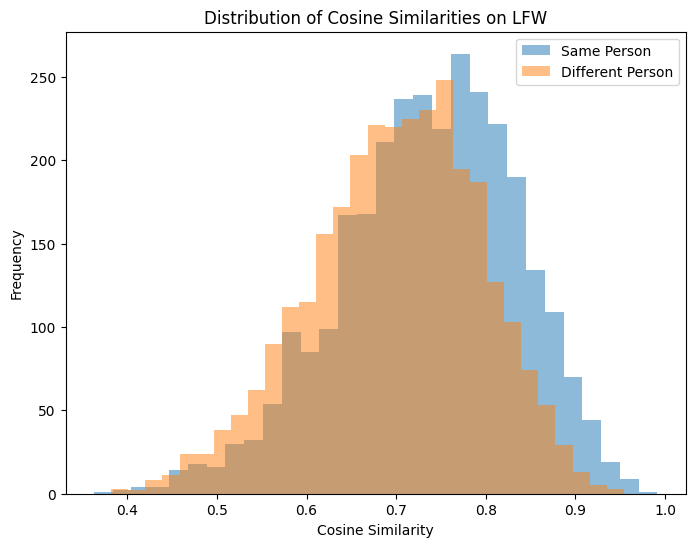

In [22]:
# Compute similarity and visualize
similarities = compute_similarity(embed1, embed2, labels)

b) Use the computed similarity scores from part a) to calculate the area under the ROC curve and the area under the precision-recall (PR) curve for your classifier model. Use the Keras `AUC` metric (see [the docs](https://keras.io/api/metrics/classification_metrics/#auc-class)) to do this.

Compute the threshold that maximises the accuracy of your classifier on the LFW test data. Plot the accuracy as a function of the threshold, and report the optimal threshold and resulting accuracy.

**(3 marks)**

In [23]:
def compute_auc_metrics(similarity_scores, labels):
    auc_roc = tf.keras.metrics.AUC(curve='ROC')
    auc_pr = tf.keras.metrics.AUC(curve='PR')
    
    auc_roc.update_state(labels, similarity_scores)
    auc_pr.update_state(labels, similarity_scores)
    
    return auc_roc.result().cpu().numpy(), auc_pr.result().cpu().numpy()


roc_auc, pr_auc = compute_auc_metrics(similarities, labels)
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")


ROC AUC: 0.6081
PR AUC: 0.6160


Optimal Threshold: 0.7678
Best Accuracy: 0.5823


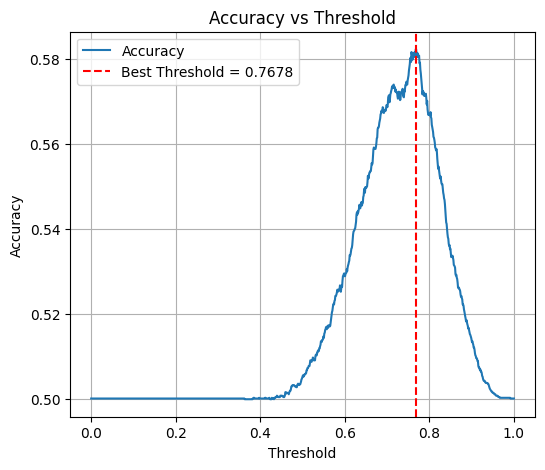

In [24]:
from sklearn.metrics import accuracy_score

# Finding the optimal threshold
thresholds = np.linspace(0, 1, 1000)
accuracies = []

for threshold in thresholds:
    predictions = (similarities >= threshold).astype(int)  # Convert similarity to binary prediction
    acc = accuracy_score(labels, predictions)
    accuracies.append(acc)

# Get the best threshold
best_idx = np.argmax(accuracies)
best_threshold = thresholds[best_idx]
best_accuracy = accuracies[best_idx]

print(f"Optimal Threshold: {best_threshold:.4f}")
print(f"Best Accuracy: {best_accuracy:.4f}")

# Plot accuracy vs. threshold
plt.figure(figsize=(6, 5))
plt.plot(thresholds, accuracies, label='Accuracy')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold = {best_threshold:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.legend()
plt.grid()
plt.show()


#### Question 4 (Total 10 marks)

Provide a separate PDF report with an account of the experiments you have run in question 2. Your report should include details of the choices you have made throughout the development of the models, including the data processing, architecture design, hyperparameter settings/experiments and training algorithm. Where appropriate, you can also provide your intuition behind these choices. 

Your report should also include the results from your experiments, highlighting the best choice of hyperparameters that you found. If you encountered difficulties to successfully train the model(s) you should report these, and if possible suggest what you think might be potential reasons for these difficulties. Are there additional experiments or modifications to the model and/or training algorithm that you would have liked to make given more time? What do you think are the most promising directions for performance gains?

Marks will be awarded for presentation and clarity. Your report should be no more than 3 pages, excluding references.

**(10 marks)**